In [1]:
import sys
print(sys.executable)

/home/zhizuo/anaconda3/bin/python


# Lego Reproduce

In [2]:
#Pre-Processing

import os
import argparse
import networkx as nx
import math        
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time
def state_to_numpy(state):
    strlist = state.split()
    val_list = [float(s) for s in strlist]
    return np.array(val_list)

def list_all_dir(data_dir):
    task_dirs = os.listdir(data_dir)

    list_dir = []
    for task_dir in task_dirs:
        env_dirs = os.listdir(data_dir+"/"+task_dir)
        for env_dir in env_dirs:
            list_dir.append(data_dir +"/"+ task_dir +"/"+ env_dir)
    return list_dir  

def process_it(G, directory):
    start = np.loadtxt(directory+"/start_nodes.txt")
    goal = np.loadtxt(directory+"/goal_nodes.txt")
    occ_grid = np.loadtxt(directory+"/occ_grid.txt")
    path_nodes = []
    i = 0
    all_data = []
    with open(directory + "/path_nodes.txt", 'r') as file:
        lines  = file.readlines()
        for line in lines:
            line = line.strip('\n')
            
            s = state_to_numpy(G.nodes[str(int(start[i]))]['state'])
            g = state_to_numpy(G.nodes[str(int(goal[i]))]['state'])
            og = occ_grid[i]
            path_nodes = str(line).split(",")
            # print(path_nodes)
            for path_node in path_nodes:
                if(path_node=='-1'):
                    continue
                node_conf = state_to_numpy(G.nodes[path_node]['state'])
                curr_node = np.array([])

                curr_node = np.concatenate((node_conf, s, g, og))
                all_data.append(curr_node)
            i+=1
    return all_data

In [3]:
G = nx.read_graphml("graphs/dense_graph.graphml")

# Loading Data

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time


# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
#learning_rate
lr = 1e-4

#problem dimensions
dim = 2
dataElements = dim * 3 + 100

z_dim = 2 #latent
X_dim = dim # samples 2
y_dim = dim # reconstruction of the original point 2
c_dim = dataElements - dim # dimension of conditioning variable 104
print("X_dim = ", X_dim)
print("c_dim = ", c_dim)
print("y_dim = ", y_dim)


X_dim =  2
c_dim =  104
y_dim =  2


In [4]:
G = nx.read_graphml("graphs/dense_graph.graphml")
data_dir = "dataset"

directory = data_dir
print(directory)
final_data = []
flag = 0

data = np.array(process_it(G, directory))

#np.random.shuffle(data)
print("shape of array: ", data.shape)

numEntries = data.shape[0]

dataset
shape of array:  (21490, 106)


In [5]:
# split the inputs and conditions into test train
# to be processed in the next step into an occupancy grid representation
ratioTestTrain = 0.8;
numTrain = int(numEntries * ratioTestTrain) # 17192 = 0.8 * 21490

# state: x, y, z, xdot, ydot, zdot
X_train = data[0:numTrain, 0:dim]
# conditions: gaps, init(6), goal(6)
c_train = data[0:numTrain, dim:dataElements] 


X_test = data[numTrain:numEntries, 0:dim] # 17192 ~ 21490
c_test = data[numTrain:numEntries, dim:dataElements] # 17192 ~ 21490

numTest = X_test.shape[0]
print(numTest)
print(numTrain)

4298
17192


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class LegoSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)
    

# CVAE Net

In [7]:
# define networks
print("X_dim = ", X_dim)
print("c_dim = ", c_dim)
print("y_dim = ", y_dim)
print()

import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(106, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(106, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
            nn.ReLU(inplace = True)
        )
        self.fc1 = nn.Linear(512, 2)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x, c):
        inputs = torch.cat((x, c), 1)
        outputs = self.encoder(inputs)
        z_mu = self.fc1(outputs)
        z_logvar = self.fc2(outputs)
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        
        inputs_1 = torch.cat((z,c), 1)
        outputs_1 = self.decoder(inputs_1)
        
        return z_mu, z_logvar, outputs_1
    

#net = CVAE()
#x1 = torch.FloatTensor(X_train[0])
#x2 = torch.FloatTensor(c_train[0])
#ret1, ret2, ret3 = net(x1,x2)
#ret1, ret2 = encoder_net(x1, x2)
#print(ret1.shape)
#print(ret2.shape)

'''
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(106, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
            nn.ReLU(inplace = True)
        )
    def forward(self, z_mu, z_logvar, c):
        eps = torch.randn(size = z_mu.shape)
        z = z_mu + torch.exp(z_logvar / 2) * eps
        inputs = torch.cat((z,c), 0)
        outputs = self.decoder(inputs)
        return outputs
    
decoder_net = Decoder()
'''
#x1 = torch.FloatTensor(torch.randn(2))
#x2 = torch.FloatTensor(torch.randn(2))
#c = torch.FloatTensor(c_train[0])
#ret = decoder_net(z_mu = x1, z_logvar = x2, c = c)
#print(ret.shape)

        
        
        

X_dim =  2
c_dim =  104
y_dim =  2



'\nclass Decoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.decoder = nn.Sequential(\n            nn.Linear(106, 512),\n            nn.ReLU(inplace = True),\n            nn.Dropout(p = 0.5),\n            nn.Linear(512, 512),\n            nn.ReLU(inplace = True),\n            nn.Linear(512, 2),\n            nn.ReLU(inplace = True)\n        )\n    def forward(self, z_mu, z_logvar, c):\n        eps = torch.randn(size = z_mu.shape)\n        z = z_mu + torch.exp(z_logvar / 2) * eps\n        inputs = torch.cat((z,c), 0)\n        outputs = self.decoder(inputs)\n        return outputs\n    \ndecoder_net = Decoder()\n'

In [8]:
path = "/Users/zhangzhizuo/Desktop/UCSD/Su Lab/Code Lego/"
train_data = LegoSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = 256, shuffle = True)
test_data = LegoSet(x = X_test, c = c_test, train = False)
test_loader = DataLoader(test_data, batch_size = 256, shuffle = False)

        


In [9]:
def KL_loss(z_mu, z_logvar):
    return 2 * torch.sum(torch.exp(z_logvar) + 
                        z_mu**2 - 1. - z_logvar, dim=1).mean()
def Recon_loss(labels, predictions):
    loss = nn.MSELoss()
    return loss(labels, predictions)

In [10]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.current_device())
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#print(time.localtime(time.time()))

True
2
GeForce GTX 1080 Ti
0


# Training

In [60]:
from torch import optim

max_epoch = 4000
lr = 1e-4
resume = "/home/zhizuo/lego/Model/lego2dCVAE_2020_3_4_0.pkl"
resume = None
net = CVAE()
if resume == None:
    net = CVAE()
else:
    net.load_state_dict(torch.load(resume))
if(torch.cuda.is_available()):
    net.cuda()
net.train()
optimizer = optim.Adam(net.parameters(), lr=lr, 
                      betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                            milestones = [50, 200, 500, 1000, 2000], gamma = 0.3)
epoch_loss = torch.zeros(max_epoch)
epoch_recon_loss = torch.zeros(max_epoch)
epoch_kl_loss = torch.zeros(max_epoch)
for epoch in range(max_epoch):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0
    for x, c in train_loader:
        i += 1
        batch_elements = [randint(0, numTrain - 1)
                         for n in range(0, 256)]
        
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss[epoch] += loss
        epoch_kl_loss[epoch] += kl_loss
        epoch_recon_loss[epoch] += recon_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
    epoch_loss[epoch] = epoch_loss[epoch] / i
    epoch_kl_loss[epoch] = epoch_kl_loss[epoch] / i
    epoch_recon_loss[epoch] = epoch_recon_loss[epoch] / i
    print("Average loss of epoch {} : Loss {:.8f} Recon {:.8f} KL {:.8f}".
          format(epoch + 1, epoch_loss[epoch], epoch_recon_loss[epoch], epoch_kl_loss[epoch]))
    if (epoch + 1) % 2000 == 0:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(), 
                  '/home/zhizuo/lego/models/CVAE_MLP_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of 2D CVAE")
net.eval() 
epoch_loss = epoch_loss.data.numpy()
epoch_recon_loss = epoch_recon_loss.data.numpy()
epoch_kl_loss = epoch_kl_loss.data.numpy()

Starting the 1 epoch
Average loss of epoch 1 : Loss 0.04997794 Recon 0.04995361 KL 0.24319974
Starting the 2 epoch
Average loss of epoch 2 : Loss 0.03666393 Recon 0.03663418 KL 0.29765067
Starting the 3 epoch
Average loss of epoch 3 : Loss 0.03317206 Recon 0.03311932 KL 0.52744150
Starting the 4 epoch
Average loss of epoch 4 : Loss 0.03113477 Recon 0.03105159 KL 0.83181715
Starting the 5 epoch
Average loss of epoch 5 : Loss 0.02987914 Recon 0.02978160 KL 0.97537065
Starting the 6 epoch
Average loss of epoch 6 : Loss 0.02908832 Recon 0.02895734 KL 1.30980110
Starting the 7 epoch
Average loss of epoch 7 : Loss 0.02797614 Recon 0.02781240 KL 1.63737810
Starting the 8 epoch
Average loss of epoch 8 : Loss 0.02557684 Recon 0.02513670 KL 4.40144062
Starting the 9 epoch
Average loss of epoch 9 : Loss 0.02168194 Recon 0.02100565 KL 6.76294756
Starting the 10 epoch
Average loss of epoch 10 : Loss 0.01850632 Recon 0.01774097 KL 7.65348101
Starting the 11 epoch
Average loss of epoch 11 : Loss 0.01

Average loss of epoch 86 : Loss 0.00743937 Recon 0.00643036 KL 10.09017563
Starting the 87 epoch
Average loss of epoch 87 : Loss 0.00740657 Recon 0.00639900 KL 10.07575130
Starting the 88 epoch
Average loss of epoch 88 : Loss 0.00733024 Recon 0.00633141 KL 9.98836517
Starting the 89 epoch
Average loss of epoch 89 : Loss 0.00734910 Recon 0.00634811 KL 10.00992012
Starting the 90 epoch
Average loss of epoch 90 : Loss 0.00735334 Recon 0.00634611 KL 10.07233238
Starting the 91 epoch
Average loss of epoch 91 : Loss 0.00723612 Recon 0.00622761 KL 10.08508492
Starting the 92 epoch
Average loss of epoch 92 : Loss 0.00736316 Recon 0.00636461 KL 9.98545837
Starting the 93 epoch
Average loss of epoch 93 : Loss 0.00725931 Recon 0.00624777 KL 10.11539268
Starting the 94 epoch
Average loss of epoch 94 : Loss 0.00719398 Recon 0.00619344 KL 10.00541782
Starting the 95 epoch
Average loss of epoch 95 : Loss 0.00715737 Recon 0.00615841 KL 9.98961544
Starting the 96 epoch
Average loss of epoch 96 : Loss 0

Average loss of epoch 170 : Loss 0.00328148 Recon 0.00177991 KL 15.01569557
Starting the 171 epoch
Average loss of epoch 171 : Loss 0.00327642 Recon 0.00176791 KL 15.08502960
Starting the 172 epoch
Average loss of epoch 172 : Loss 0.00327781 Recon 0.00178283 KL 14.94984436
Starting the 173 epoch
Average loss of epoch 173 : Loss 0.00328383 Recon 0.00178415 KL 14.99683285
Starting the 174 epoch
Average loss of epoch 174 : Loss 0.00325815 Recon 0.00176797 KL 14.90180206
Starting the 175 epoch
Average loss of epoch 175 : Loss 0.00319357 Recon 0.00169482 KL 14.98746014
Starting the 176 epoch
Average loss of epoch 176 : Loss 0.00323843 Recon 0.00174560 KL 14.92830181
Starting the 177 epoch
Average loss of epoch 177 : Loss 0.00320978 Recon 0.00172012 KL 14.89667416
Starting the 178 epoch
Average loss of epoch 178 : Loss 0.00322078 Recon 0.00172401 KL 14.96762657
Starting the 179 epoch
Average loss of epoch 179 : Loss 0.00317859 Recon 0.00168277 KL 14.95825863
Starting the 180 epoch
Average lo

Average loss of epoch 253 : Loss 0.00274427 Recon 0.00129660 KL 14.47673130
Starting the 254 epoch
Average loss of epoch 254 : Loss 0.00272353 Recon 0.00127914 KL 14.44391441
Starting the 255 epoch
Average loss of epoch 255 : Loss 0.00272349 Recon 0.00127455 KL 14.48938656
Starting the 256 epoch
Average loss of epoch 256 : Loss 0.00271068 Recon 0.00126181 KL 14.48866749
Starting the 257 epoch
Average loss of epoch 257 : Loss 0.00273829 Recon 0.00129426 KL 14.44025421
Starting the 258 epoch
Average loss of epoch 258 : Loss 0.00272213 Recon 0.00127755 KL 14.44577026
Starting the 259 epoch
Average loss of epoch 259 : Loss 0.00272336 Recon 0.00127464 KL 14.48712826
Starting the 260 epoch
Average loss of epoch 260 : Loss 0.00267945 Recon 0.00124702 KL 14.32422829
Starting the 261 epoch
Average loss of epoch 261 : Loss 0.00269895 Recon 0.00125965 KL 14.39300728
Starting the 262 epoch
Average loss of epoch 262 : Loss 0.00268421 Recon 0.00124330 KL 14.40908527
Starting the 263 epoch
Average lo

Average loss of epoch 336 : Loss 0.00250138 Recon 0.00110175 KL 13.99626350
Starting the 337 epoch
Average loss of epoch 337 : Loss 0.00250630 Recon 0.00109885 KL 14.07449341
Starting the 338 epoch
Average loss of epoch 338 : Loss 0.00249106 Recon 0.00108601 KL 14.05052948
Starting the 339 epoch
Average loss of epoch 339 : Loss 0.00249877 Recon 0.00109549 KL 14.03282070
Starting the 340 epoch
Average loss of epoch 340 : Loss 0.00247866 Recon 0.00108592 KL 13.92732716
Starting the 341 epoch
Average loss of epoch 341 : Loss 0.00247574 Recon 0.00107521 KL 14.00530243
Starting the 342 epoch
Average loss of epoch 342 : Loss 0.00250032 Recon 0.00109161 KL 14.08710194
Starting the 343 epoch
Average loss of epoch 343 : Loss 0.00247816 Recon 0.00107702 KL 14.01134872
Starting the 344 epoch
Average loss of epoch 344 : Loss 0.00249971 Recon 0.00109340 KL 14.06316471
Starting the 345 epoch
Average loss of epoch 345 : Loss 0.00249969 Recon 0.00108787 KL 14.11817360
Starting the 346 epoch
Average lo

Average loss of epoch 419 : Loss 0.00236745 Recon 0.00099107 KL 13.76378250
Starting the 420 epoch
Average loss of epoch 420 : Loss 0.00236623 Recon 0.00099494 KL 13.71292686
Starting the 421 epoch
Average loss of epoch 421 : Loss 0.00236251 Recon 0.00098548 KL 13.77026272
Starting the 422 epoch
Average loss of epoch 422 : Loss 0.00235402 Recon 0.00097458 KL 13.79440784
Starting the 423 epoch
Average loss of epoch 423 : Loss 0.00236461 Recon 0.00098769 KL 13.76918888
Starting the 424 epoch
Average loss of epoch 424 : Loss 0.00235822 Recon 0.00098323 KL 13.74993134
Starting the 425 epoch
Average loss of epoch 425 : Loss 0.00237240 Recon 0.00098998 KL 13.82422829
Starting the 426 epoch
Average loss of epoch 426 : Loss 0.00236198 Recon 0.00098643 KL 13.75553226
Starting the 427 epoch
Average loss of epoch 427 : Loss 0.00235730 Recon 0.00097499 KL 13.82313538
Starting the 428 epoch
Average loss of epoch 428 : Loss 0.00235963 Recon 0.00098146 KL 13.78172684
Starting the 429 epoch
Average lo

Average loss of epoch 502 : Loss 0.00229247 Recon 0.00093456 KL 13.57906342
Starting the 503 epoch
Average loss of epoch 503 : Loss 0.00226751 Recon 0.00090784 KL 13.59673786
Starting the 504 epoch
Average loss of epoch 504 : Loss 0.00227883 Recon 0.00091690 KL 13.61922646
Starting the 505 epoch
Average loss of epoch 505 : Loss 0.00228236 Recon 0.00093905 KL 13.43310261
Starting the 506 epoch
Average loss of epoch 506 : Loss 0.00229505 Recon 0.00093001 KL 13.65035248
Starting the 507 epoch
Average loss of epoch 507 : Loss 0.00226586 Recon 0.00091214 KL 13.53725243
Starting the 508 epoch
Average loss of epoch 508 : Loss 0.00227409 Recon 0.00091833 KL 13.55758381
Starting the 509 epoch
Average loss of epoch 509 : Loss 0.00227201 Recon 0.00091353 KL 13.58484936
Starting the 510 epoch
Average loss of epoch 510 : Loss 0.00227002 Recon 0.00091018 KL 13.59844112
Starting the 511 epoch
Average loss of epoch 511 : Loss 0.00227215 Recon 0.00091753 KL 13.54617596
Starting the 512 epoch
Average lo

Average loss of epoch 585 : Loss 0.00221312 Recon 0.00086671 KL 13.46407700
Starting the 586 epoch
Average loss of epoch 586 : Loss 0.00223421 Recon 0.00088554 KL 13.48668385
Starting the 587 epoch
Average loss of epoch 587 : Loss 0.00222572 Recon 0.00088180 KL 13.43917084
Starting the 588 epoch
Average loss of epoch 588 : Loss 0.00219756 Recon 0.00086170 KL 13.35861397
Starting the 589 epoch
Average loss of epoch 589 : Loss 0.00220026 Recon 0.00086080 KL 13.39461803
Starting the 590 epoch
Average loss of epoch 590 : Loss 0.00220699 Recon 0.00087185 KL 13.35142899
Starting the 591 epoch
Average loss of epoch 591 : Loss 0.00221997 Recon 0.00087087 KL 13.49106884
Starting the 592 epoch
Average loss of epoch 592 : Loss 0.00222051 Recon 0.00087906 KL 13.41448212
Starting the 593 epoch
Average loss of epoch 593 : Loss 0.00221538 Recon 0.00087535 KL 13.40025902
Starting the 594 epoch
Average loss of epoch 594 : Loss 0.00220731 Recon 0.00085507 KL 13.52237988
Starting the 595 epoch
Average lo

Average loss of epoch 668 : Loss 0.00214355 Recon 0.00081836 KL 13.25189590
Starting the 669 epoch
Average loss of epoch 669 : Loss 0.00217200 Recon 0.00085031 KL 13.21684456
Starting the 670 epoch
Average loss of epoch 670 : Loss 0.00215042 Recon 0.00082687 KL 13.23558521
Starting the 671 epoch
Average loss of epoch 671 : Loss 0.00215755 Recon 0.00083233 KL 13.25221539
Starting the 672 epoch
Average loss of epoch 672 : Loss 0.00215713 Recon 0.00083107 KL 13.26055050
Starting the 673 epoch
Average loss of epoch 673 : Loss 0.00216130 Recon 0.00083438 KL 13.26929474
Starting the 674 epoch
Average loss of epoch 674 : Loss 0.00215903 Recon 0.00084151 KL 13.17522335
Starting the 675 epoch
Average loss of epoch 675 : Loss 0.00215328 Recon 0.00083049 KL 13.22785759
Starting the 676 epoch
Average loss of epoch 676 : Loss 0.00216082 Recon 0.00084229 KL 13.18521595
Starting the 677 epoch
Average loss of epoch 677 : Loss 0.00216399 Recon 0.00083681 KL 13.27177811
Starting the 678 epoch
Average lo

Average loss of epoch 751 : Loss 0.00215240 Recon 0.00082011 KL 13.32291222
Starting the 752 epoch
Average loss of epoch 752 : Loss 0.00213105 Recon 0.00081468 KL 13.16364956
Starting the 753 epoch
Average loss of epoch 753 : Loss 0.00212224 Recon 0.00080727 KL 13.14969349
Starting the 754 epoch
Average loss of epoch 754 : Loss 0.00213717 Recon 0.00081844 KL 13.18728638
Starting the 755 epoch
Average loss of epoch 755 : Loss 0.00213305 Recon 0.00081968 KL 13.13372231
Starting the 756 epoch
Average loss of epoch 756 : Loss 0.00213848 Recon 0.00082540 KL 13.13075352
Starting the 757 epoch
Average loss of epoch 757 : Loss 0.00212383 Recon 0.00080712 KL 13.16706753
Starting the 758 epoch
Average loss of epoch 758 : Loss 0.00213360 Recon 0.00081177 KL 13.21833420
Starting the 759 epoch
Average loss of epoch 759 : Loss 0.00214251 Recon 0.00082384 KL 13.18661022
Starting the 760 epoch
Average loss of epoch 760 : Loss 0.00213482 Recon 0.00081744 KL 13.17377567
Starting the 761 epoch
Average lo

Average loss of epoch 834 : Loss 0.00211016 Recon 0.00079563 KL 13.14534760
Starting the 835 epoch
Average loss of epoch 835 : Loss 0.00209731 Recon 0.00078875 KL 13.08553314
Starting the 836 epoch
Average loss of epoch 836 : Loss 0.00210488 Recon 0.00079549 KL 13.09385204
Starting the 837 epoch
Average loss of epoch 837 : Loss 0.00209578 Recon 0.00078811 KL 13.07662201
Starting the 838 epoch
Average loss of epoch 838 : Loss 0.00210035 Recon 0.00079719 KL 13.03162766
Starting the 839 epoch
Average loss of epoch 839 : Loss 0.00209815 Recon 0.00078741 KL 13.10737419
Starting the 840 epoch
Average loss of epoch 840 : Loss 0.00211580 Recon 0.00080752 KL 13.08280945
Starting the 841 epoch
Average loss of epoch 841 : Loss 0.00208576 Recon 0.00078265 KL 13.03105736
Starting the 842 epoch
Average loss of epoch 842 : Loss 0.00210957 Recon 0.00079983 KL 13.09738922
Starting the 843 epoch
Average loss of epoch 843 : Loss 0.00210627 Recon 0.00078991 KL 13.16355896
Starting the 844 epoch
Average lo

Average loss of epoch 917 : Loss 0.00207917 Recon 0.00077618 KL 13.02990437
Starting the 918 epoch
Average loss of epoch 918 : Loss 0.00206663 Recon 0.00076779 KL 12.98840332
Starting the 919 epoch
Average loss of epoch 919 : Loss 0.00208350 Recon 0.00078443 KL 12.99067020
Starting the 920 epoch
Average loss of epoch 920 : Loss 0.00209224 Recon 0.00078998 KL 13.02265453
Starting the 921 epoch
Average loss of epoch 921 : Loss 0.00207940 Recon 0.00076650 KL 13.12891865
Starting the 922 epoch
Average loss of epoch 922 : Loss 0.00205907 Recon 0.00076178 KL 12.97292805
Starting the 923 epoch
Average loss of epoch 923 : Loss 0.00206604 Recon 0.00076827 KL 12.97766876
Starting the 924 epoch
Average loss of epoch 924 : Loss 0.00206797 Recon 0.00076928 KL 12.98689747
Starting the 925 epoch
Average loss of epoch 925 : Loss 0.00207140 Recon 0.00078212 KL 12.89281464
Starting the 926 epoch
Average loss of epoch 926 : Loss 0.00206991 Recon 0.00077013 KL 12.99776745
Starting the 927 epoch
Average lo

Average loss of epoch 1000 : Loss 0.00205525 Recon 0.00076238 KL 12.92871952
Starting the 1001 epoch
Average loss of epoch 1001 : Loss 0.00205087 Recon 0.00075741 KL 12.93457890
Starting the 1002 epoch
Average loss of epoch 1002 : Loss 0.00206123 Recon 0.00076104 KL 13.00186825
Starting the 1003 epoch
Average loss of epoch 1003 : Loss 0.00204797 Recon 0.00075095 KL 12.97011852
Starting the 1004 epoch
Average loss of epoch 1004 : Loss 0.00204892 Recon 0.00076257 KL 12.86353493
Starting the 1005 epoch
Average loss of epoch 1005 : Loss 0.00205089 Recon 0.00075866 KL 12.92229271
Starting the 1006 epoch
Average loss of epoch 1006 : Loss 0.00205428 Recon 0.00075996 KL 12.94320869
Starting the 1007 epoch
Average loss of epoch 1007 : Loss 0.00205087 Recon 0.00075958 KL 12.91285896
Starting the 1008 epoch
Average loss of epoch 1008 : Loss 0.00204289 Recon 0.00075058 KL 12.92314720
Starting the 1009 epoch
Average loss of epoch 1009 : Loss 0.00202835 Recon 0.00074306 KL 12.85286713
Starting the 1

Average loss of epoch 1082 : Loss 0.00205141 Recon 0.00075080 KL 13.00606155
Starting the 1083 epoch
Average loss of epoch 1083 : Loss 0.00202193 Recon 0.00073720 KL 12.84732056
Starting the 1084 epoch
Average loss of epoch 1084 : Loss 0.00201948 Recon 0.00073565 KL 12.83831406
Starting the 1085 epoch
Average loss of epoch 1085 : Loss 0.00202588 Recon 0.00074688 KL 12.78992748
Starting the 1086 epoch
Average loss of epoch 1086 : Loss 0.00204089 Recon 0.00074887 KL 12.92029095
Starting the 1087 epoch
Average loss of epoch 1087 : Loss 0.00202787 Recon 0.00073865 KL 12.89218616
Starting the 1088 epoch
Average loss of epoch 1088 : Loss 0.00203487 Recon 0.00075065 KL 12.84227085
Starting the 1089 epoch
Average loss of epoch 1089 : Loss 0.00204711 Recon 0.00075142 KL 12.95687294
Starting the 1090 epoch
Average loss of epoch 1090 : Loss 0.00201788 Recon 0.00074210 KL 12.75783539
Starting the 1091 epoch
Average loss of epoch 1091 : Loss 0.00204521 Recon 0.00074571 KL 12.99496937
Starting the 1

Average loss of epoch 1164 : Loss 0.00202757 Recon 0.00074587 KL 12.81697559
Starting the 1165 epoch
Average loss of epoch 1165 : Loss 0.00201161 Recon 0.00073244 KL 12.79172993
Starting the 1166 epoch
Average loss of epoch 1166 : Loss 0.00200342 Recon 0.00072536 KL 12.78059387
Starting the 1167 epoch
Average loss of epoch 1167 : Loss 0.00201027 Recon 0.00073285 KL 12.77417660
Starting the 1168 epoch
Average loss of epoch 1168 : Loss 0.00201384 Recon 0.00073156 KL 12.82279301
Starting the 1169 epoch
Average loss of epoch 1169 : Loss 0.00202365 Recon 0.00072912 KL 12.94524670
Starting the 1170 epoch
Average loss of epoch 1170 : Loss 0.00202986 Recon 0.00074206 KL 12.87800789
Starting the 1171 epoch
Average loss of epoch 1171 : Loss 0.00201007 Recon 0.00073275 KL 12.77323151
Starting the 1172 epoch
Average loss of epoch 1172 : Loss 0.00200143 Recon 0.00071836 KL 12.83071327
Starting the 1173 epoch
Average loss of epoch 1173 : Loss 0.00201384 Recon 0.00073059 KL 12.83251286
Starting the 1

Average loss of epoch 1246 : Loss 0.00199784 Recon 0.00073106 KL 12.66784573
Starting the 1247 epoch
Average loss of epoch 1247 : Loss 0.00199526 Recon 0.00073084 KL 12.64422035
Starting the 1248 epoch
Average loss of epoch 1248 : Loss 0.00202022 Recon 0.00074150 KL 12.78724766
Starting the 1249 epoch
Average loss of epoch 1249 : Loss 0.00199799 Recon 0.00072498 KL 12.73008156
Starting the 1250 epoch
Average loss of epoch 1250 : Loss 0.00200570 Recon 0.00072870 KL 12.77000237
Starting the 1251 epoch
Average loss of epoch 1251 : Loss 0.00200683 Recon 0.00073311 KL 12.73725796
Starting the 1252 epoch
Average loss of epoch 1252 : Loss 0.00199808 Recon 0.00072106 KL 12.77025318
Starting the 1253 epoch
Average loss of epoch 1253 : Loss 0.00200127 Recon 0.00072539 KL 12.75878906
Starting the 1254 epoch
Average loss of epoch 1254 : Loss 0.00199090 Recon 0.00071992 KL 12.70975494
Starting the 1255 epoch
Average loss of epoch 1255 : Loss 0.00200034 Recon 0.00072723 KL 12.73110199
Starting the 1

Average loss of epoch 1328 : Loss 0.00197532 Recon 0.00071090 KL 12.64410782
Starting the 1329 epoch
Average loss of epoch 1329 : Loss 0.00199693 Recon 0.00072678 KL 12.70146751
Starting the 1330 epoch
Average loss of epoch 1330 : Loss 0.00201538 Recon 0.00073459 KL 12.80795860
Starting the 1331 epoch
Average loss of epoch 1331 : Loss 0.00199192 Recon 0.00071940 KL 12.72523499
Starting the 1332 epoch
Average loss of epoch 1332 : Loss 0.00197374 Recon 0.00071152 KL 12.62221909
Starting the 1333 epoch
Average loss of epoch 1333 : Loss 0.00200731 Recon 0.00072037 KL 12.86940956
Starting the 1334 epoch
Average loss of epoch 1334 : Loss 0.00200429 Recon 0.00072286 KL 12.81431770
Starting the 1335 epoch
Average loss of epoch 1335 : Loss 0.00199113 Recon 0.00071208 KL 12.79056835
Starting the 1336 epoch
Average loss of epoch 1336 : Loss 0.00197551 Recon 0.00070358 KL 12.71925640
Starting the 1337 epoch
Average loss of epoch 1337 : Loss 0.00197898 Recon 0.00070690 KL 12.72082329
Starting the 1

Average loss of epoch 1410 : Loss 0.00196492 Recon 0.00069659 KL 12.68331623
Starting the 1411 epoch
Average loss of epoch 1411 : Loss 0.00197630 Recon 0.00071416 KL 12.62137127
Starting the 1412 epoch
Average loss of epoch 1412 : Loss 0.00198220 Recon 0.00070633 KL 12.75866890
Starting the 1413 epoch
Average loss of epoch 1413 : Loss 0.00198888 Recon 0.00071803 KL 12.70843124
Starting the 1414 epoch
Average loss of epoch 1414 : Loss 0.00197250 Recon 0.00070308 KL 12.69427109
Starting the 1415 epoch
Average loss of epoch 1415 : Loss 0.00198220 Recon 0.00071194 KL 12.70263195
Starting the 1416 epoch
Average loss of epoch 1416 : Loss 0.00197835 Recon 0.00071585 KL 12.62497997
Starting the 1417 epoch
Average loss of epoch 1417 : Loss 0.00199489 Recon 0.00072149 KL 12.73396492
Starting the 1418 epoch
Average loss of epoch 1418 : Loss 0.00198623 Recon 0.00071534 KL 12.70889759
Starting the 1419 epoch
Average loss of epoch 1419 : Loss 0.00196505 Recon 0.00070038 KL 12.64672375
Starting the 1

Average loss of epoch 1492 : Loss 0.00197307 Recon 0.00070986 KL 12.63209534
Starting the 1493 epoch
Average loss of epoch 1493 : Loss 0.00195902 Recon 0.00070301 KL 12.56010437
Starting the 1494 epoch
Average loss of epoch 1494 : Loss 0.00197104 Recon 0.00071008 KL 12.60963154
Starting the 1495 epoch
Average loss of epoch 1495 : Loss 0.00196818 Recon 0.00070369 KL 12.64490128
Starting the 1496 epoch
Average loss of epoch 1496 : Loss 0.00196602 Recon 0.00071087 KL 12.55147648
Starting the 1497 epoch
Average loss of epoch 1497 : Loss 0.00196623 Recon 0.00070166 KL 12.64565086
Starting the 1498 epoch
Average loss of epoch 1498 : Loss 0.00197747 Recon 0.00071398 KL 12.63493156
Starting the 1499 epoch
Average loss of epoch 1499 : Loss 0.00196812 Recon 0.00070491 KL 12.63211441
Starting the 1500 epoch
Average loss of epoch 1500 : Loss 0.00196584 Recon 0.00069970 KL 12.66140366
Starting the 1501 epoch
Average loss of epoch 1501 : Loss 0.00197713 Recon 0.00071051 KL 12.66614532
Starting the 1

Average loss of epoch 1574 : Loss 0.00194004 Recon 0.00067750 KL 12.62548542
Starting the 1575 epoch
Average loss of epoch 1575 : Loss 0.00195119 Recon 0.00069179 KL 12.59400749
Starting the 1576 epoch
Average loss of epoch 1576 : Loss 0.00194838 Recon 0.00068799 KL 12.60393429
Starting the 1577 epoch
Average loss of epoch 1577 : Loss 0.00194397 Recon 0.00068494 KL 12.59031963
Starting the 1578 epoch
Average loss of epoch 1578 : Loss 0.00197821 Recon 0.00071621 KL 12.62002468
Starting the 1579 epoch
Average loss of epoch 1579 : Loss 0.00195519 Recon 0.00069146 KL 12.63733101
Starting the 1580 epoch
Average loss of epoch 1580 : Loss 0.00195219 Recon 0.00069267 KL 12.59517479
Starting the 1581 epoch
Average loss of epoch 1581 : Loss 0.00195152 Recon 0.00068769 KL 12.63832951
Starting the 1582 epoch
Average loss of epoch 1582 : Loss 0.00195650 Recon 0.00069306 KL 12.63430882
Starting the 1583 epoch
Average loss of epoch 1583 : Loss 0.00196171 Recon 0.00069129 KL 12.70422649
Starting the 1

Average loss of epoch 1656 : Loss 0.00193883 Recon 0.00069163 KL 12.47208595
Starting the 1657 epoch
Average loss of epoch 1657 : Loss 0.00196438 Recon 0.00069785 KL 12.66523552
Starting the 1658 epoch
Average loss of epoch 1658 : Loss 0.00195222 Recon 0.00069156 KL 12.60667419
Starting the 1659 epoch
Average loss of epoch 1659 : Loss 0.00194069 Recon 0.00068426 KL 12.56422234
Starting the 1660 epoch
Average loss of epoch 1660 : Loss 0.00194348 Recon 0.00069053 KL 12.52954197
Starting the 1661 epoch
Average loss of epoch 1661 : Loss 0.00194212 Recon 0.00068535 KL 12.56770802
Starting the 1662 epoch
Average loss of epoch 1662 : Loss 0.00194564 Recon 0.00069167 KL 12.53962708
Starting the 1663 epoch
Average loss of epoch 1663 : Loss 0.00194883 Recon 0.00069176 KL 12.57065105
Starting the 1664 epoch
Average loss of epoch 1664 : Loss 0.00195443 Recon 0.00069683 KL 12.57603931
Starting the 1665 epoch
Average loss of epoch 1665 : Loss 0.00195512 Recon 0.00068929 KL 12.65833282
Starting the 1

Average loss of epoch 1738 : Loss 0.00194407 Recon 0.00068232 KL 12.61749172
Starting the 1739 epoch
Average loss of epoch 1739 : Loss 0.00193434 Recon 0.00069159 KL 12.42754841
Starting the 1740 epoch
Average loss of epoch 1740 : Loss 0.00193936 Recon 0.00067735 KL 12.62013054
Starting the 1741 epoch
Average loss of epoch 1741 : Loss 0.00193655 Recon 0.00068915 KL 12.47401905
Starting the 1742 epoch
Average loss of epoch 1742 : Loss 0.00194058 Recon 0.00069529 KL 12.45290089
Starting the 1743 epoch
Average loss of epoch 1743 : Loss 0.00195446 Recon 0.00069639 KL 12.58067799
Starting the 1744 epoch
Average loss of epoch 1744 : Loss 0.00193744 Recon 0.00067636 KL 12.61077118
Starting the 1745 epoch
Average loss of epoch 1745 : Loss 0.00194918 Recon 0.00067640 KL 12.72782421
Starting the 1746 epoch
Average loss of epoch 1746 : Loss 0.00192536 Recon 0.00066571 KL 12.59650230
Starting the 1747 epoch
Average loss of epoch 1747 : Loss 0.00194194 Recon 0.00069055 KL 12.51390839
Starting the 1

Average loss of epoch 1820 : Loss 0.00193515 Recon 0.00068040 KL 12.54751587
Starting the 1821 epoch
Average loss of epoch 1821 : Loss 0.00192877 Recon 0.00067209 KL 12.56679058
Starting the 1822 epoch
Average loss of epoch 1822 : Loss 0.00194696 Recon 0.00068706 KL 12.59897614
Starting the 1823 epoch
Average loss of epoch 1823 : Loss 0.00191460 Recon 0.00066263 KL 12.51969814
Starting the 1824 epoch
Average loss of epoch 1824 : Loss 0.00194471 Recon 0.00068793 KL 12.56782150
Starting the 1825 epoch
Average loss of epoch 1825 : Loss 0.00192826 Recon 0.00067174 KL 12.56517601
Starting the 1826 epoch
Average loss of epoch 1826 : Loss 0.00192115 Recon 0.00067491 KL 12.46237087
Starting the 1827 epoch
Average loss of epoch 1827 : Loss 0.00191813 Recon 0.00067426 KL 12.43871117
Starting the 1828 epoch
Average loss of epoch 1828 : Loss 0.00191102 Recon 0.00066129 KL 12.49730682
Starting the 1829 epoch
Average loss of epoch 1829 : Loss 0.00192498 Recon 0.00067831 KL 12.46672344
Starting the 1

Average loss of epoch 1902 : Loss 0.00192548 Recon 0.00067971 KL 12.45773697
Starting the 1903 epoch
Average loss of epoch 1903 : Loss 0.00191060 Recon 0.00067095 KL 12.39650345
Starting the 1904 epoch
Average loss of epoch 1904 : Loss 0.00192641 Recon 0.00067895 KL 12.47457790
Starting the 1905 epoch
Average loss of epoch 1905 : Loss 0.00191875 Recon 0.00067010 KL 12.48646259
Starting the 1906 epoch
Average loss of epoch 1906 : Loss 0.00193331 Recon 0.00068522 KL 12.48089409
Starting the 1907 epoch
Average loss of epoch 1907 : Loss 0.00190814 Recon 0.00066538 KL 12.42768192
Starting the 1908 epoch
Average loss of epoch 1908 : Loss 0.00192421 Recon 0.00068383 KL 12.40373325
Starting the 1909 epoch
Average loss of epoch 1909 : Loss 0.00194270 Recon 0.00068175 KL 12.60958099
Starting the 1910 epoch
Average loss of epoch 1910 : Loss 0.00191435 Recon 0.00066820 KL 12.46146679
Starting the 1911 epoch
Average loss of epoch 1911 : Loss 0.00193341 Recon 0.00066841 KL 12.64997292
Starting the 1

Average loss of epoch 1984 : Loss 0.00192152 Recon 0.00067586 KL 12.45663643
Starting the 1985 epoch
Average loss of epoch 1985 : Loss 0.00190165 Recon 0.00065370 KL 12.47944069
Starting the 1986 epoch
Average loss of epoch 1986 : Loss 0.00190713 Recon 0.00067118 KL 12.35945606
Starting the 1987 epoch
Average loss of epoch 1987 : Loss 0.00191322 Recon 0.00066496 KL 12.48263741
Starting the 1988 epoch
Average loss of epoch 1988 : Loss 0.00192961 Recon 0.00067446 KL 12.55150032
Starting the 1989 epoch
Average loss of epoch 1989 : Loss 0.00191334 Recon 0.00065894 KL 12.54402924
Starting the 1990 epoch
Average loss of epoch 1990 : Loss 0.00192029 Recon 0.00067016 KL 12.50133801
Starting the 1991 epoch
Average loss of epoch 1991 : Loss 0.00191531 Recon 0.00067317 KL 12.42140770
Starting the 1992 epoch
Average loss of epoch 1992 : Loss 0.00191308 Recon 0.00066915 KL 12.43926430
Starting the 1993 epoch
Average loss of epoch 1993 : Loss 0.00191034 Recon 0.00066329 KL 12.47051430
Starting the 1

Average loss of epoch 2065 : Loss 0.00189406 Recon 0.00064859 KL 12.45468235
Starting the 2066 epoch
Average loss of epoch 2066 : Loss 0.00190849 Recon 0.00067131 KL 12.37185764
Starting the 2067 epoch
Average loss of epoch 2067 : Loss 0.00189156 Recon 0.00064989 KL 12.41670895
Starting the 2068 epoch
Average loss of epoch 2068 : Loss 0.00190354 Recon 0.00066233 KL 12.41206932
Starting the 2069 epoch
Average loss of epoch 2069 : Loss 0.00190805 Recon 0.00065961 KL 12.48439598
Starting the 2070 epoch
Average loss of epoch 2070 : Loss 0.00189855 Recon 0.00065106 KL 12.47493076
Starting the 2071 epoch
Average loss of epoch 2071 : Loss 0.00193105 Recon 0.00068578 KL 12.45270443
Starting the 2072 epoch
Average loss of epoch 2072 : Loss 0.00191101 Recon 0.00066359 KL 12.47416973
Starting the 2073 epoch
Average loss of epoch 2073 : Loss 0.00191590 Recon 0.00067397 KL 12.41928196
Starting the 2074 epoch
Average loss of epoch 2074 : Loss 0.00191770 Recon 0.00067377 KL 12.43935299
Starting the 2

Average loss of epoch 2147 : Loss 0.00190042 Recon 0.00066546 KL 12.34958649
Starting the 2148 epoch
Average loss of epoch 2148 : Loss 0.00190273 Recon 0.00065580 KL 12.46931553
Starting the 2149 epoch
Average loss of epoch 2149 : Loss 0.00191384 Recon 0.00067270 KL 12.41140079
Starting the 2150 epoch
Average loss of epoch 2150 : Loss 0.00188274 Recon 0.00064314 KL 12.39601803
Starting the 2151 epoch
Average loss of epoch 2151 : Loss 0.00189960 Recon 0.00065576 KL 12.43839645
Starting the 2152 epoch
Average loss of epoch 2152 : Loss 0.00192580 Recon 0.00068540 KL 12.40396881
Starting the 2153 epoch
Average loss of epoch 2153 : Loss 0.00189988 Recon 0.00065192 KL 12.47957134
Starting the 2154 epoch
Average loss of epoch 2154 : Loss 0.00191108 Recon 0.00066095 KL 12.50122833
Starting the 2155 epoch
Average loss of epoch 2155 : Loss 0.00189607 Recon 0.00065607 KL 12.39994907
Starting the 2156 epoch
Average loss of epoch 2156 : Loss 0.00191365 Recon 0.00066574 KL 12.47913170
Starting the 2

Average loss of epoch 2229 : Loss 0.00190497 Recon 0.00067032 KL 12.34648705
Starting the 2230 epoch
Average loss of epoch 2230 : Loss 0.00189339 Recon 0.00065348 KL 12.39906311
Starting the 2231 epoch
Average loss of epoch 2231 : Loss 0.00190798 Recon 0.00066916 KL 12.38829803
Starting the 2232 epoch
Average loss of epoch 2232 : Loss 0.00188455 Recon 0.00065342 KL 12.31133175
Starting the 2233 epoch
Average loss of epoch 2233 : Loss 0.00188404 Recon 0.00065018 KL 12.33864212
Starting the 2234 epoch
Average loss of epoch 2234 : Loss 0.00187755 Recon 0.00064344 KL 12.34103394
Starting the 2235 epoch
Average loss of epoch 2235 : Loss 0.00188878 Recon 0.00065117 KL 12.37611103
Starting the 2236 epoch
Average loss of epoch 2236 : Loss 0.00187772 Recon 0.00064780 KL 12.29920197
Starting the 2237 epoch
Average loss of epoch 2237 : Loss 0.00189513 Recon 0.00065755 KL 12.37581348
Starting the 2238 epoch
Average loss of epoch 2238 : Loss 0.00190787 Recon 0.00066378 KL 12.44092464
Starting the 2

Average loss of epoch 2311 : Loss 0.00188481 Recon 0.00064485 KL 12.39963055
Starting the 2312 epoch
Average loss of epoch 2312 : Loss 0.00190010 Recon 0.00065901 KL 12.41089916
Starting the 2313 epoch
Average loss of epoch 2313 : Loss 0.00190117 Recon 0.00065664 KL 12.44531536
Starting the 2314 epoch
Average loss of epoch 2314 : Loss 0.00191558 Recon 0.00066333 KL 12.52253532
Starting the 2315 epoch
Average loss of epoch 2315 : Loss 0.00188792 Recon 0.00064370 KL 12.44218731
Starting the 2316 epoch
Average loss of epoch 2316 : Loss 0.00187668 Recon 0.00064658 KL 12.30095196
Starting the 2317 epoch
Average loss of epoch 2317 : Loss 0.00190049 Recon 0.00066392 KL 12.36573219
Starting the 2318 epoch
Average loss of epoch 2318 : Loss 0.00188171 Recon 0.00064362 KL 12.38093758
Starting the 2319 epoch
Average loss of epoch 2319 : Loss 0.00189400 Recon 0.00064910 KL 12.44895840
Starting the 2320 epoch
Average loss of epoch 2320 : Loss 0.00191062 Recon 0.00067205 KL 12.38565636
Starting the 2

Average loss of epoch 2393 : Loss 0.00187031 Recon 0.00064035 KL 12.29951286
Starting the 2394 epoch
Average loss of epoch 2394 : Loss 0.00187334 Recon 0.00063610 KL 12.37244320
Starting the 2395 epoch
Average loss of epoch 2395 : Loss 0.00189492 Recon 0.00065264 KL 12.42279148
Starting the 2396 epoch
Average loss of epoch 2396 : Loss 0.00191438 Recon 0.00066009 KL 12.54293537
Starting the 2397 epoch
Average loss of epoch 2397 : Loss 0.00189566 Recon 0.00065462 KL 12.41041756
Starting the 2398 epoch
Average loss of epoch 2398 : Loss 0.00188249 Recon 0.00064230 KL 12.40188122
Starting the 2399 epoch
Average loss of epoch 2399 : Loss 0.00188742 Recon 0.00065130 KL 12.36122131
Starting the 2400 epoch
Average loss of epoch 2400 : Loss 0.00190067 Recon 0.00066653 KL 12.34145164
Starting the 2401 epoch
Average loss of epoch 2401 : Loss 0.00188336 Recon 0.00064224 KL 12.41124153
Starting the 2402 epoch
Average loss of epoch 2402 : Loss 0.00188796 Recon 0.00065790 KL 12.30061626
Starting the 2

Average loss of epoch 2475 : Loss 0.00189378 Recon 0.00065666 KL 12.37119293
Starting the 2476 epoch
Average loss of epoch 2476 : Loss 0.00187129 Recon 0.00063669 KL 12.34595776
Starting the 2477 epoch
Average loss of epoch 2477 : Loss 0.00188593 Recon 0.00065259 KL 12.33339691
Starting the 2478 epoch
Average loss of epoch 2478 : Loss 0.00189021 Recon 0.00065443 KL 12.35775757
Starting the 2479 epoch
Average loss of epoch 2479 : Loss 0.00188648 Recon 0.00065305 KL 12.33430672
Starting the 2480 epoch
Average loss of epoch 2480 : Loss 0.00188188 Recon 0.00064442 KL 12.37460041
Starting the 2481 epoch
Average loss of epoch 2481 : Loss 0.00188235 Recon 0.00065273 KL 12.29620934
Starting the 2482 epoch
Average loss of epoch 2482 : Loss 0.00189606 Recon 0.00064926 KL 12.46795940
Starting the 2483 epoch
Average loss of epoch 2483 : Loss 0.00188352 Recon 0.00065451 KL 12.29010010
Starting the 2484 epoch
Average loss of epoch 2484 : Loss 0.00189009 Recon 0.00065735 KL 12.32739162
Starting the 2

Average loss of epoch 2557 : Loss 0.00186386 Recon 0.00064257 KL 12.21290207
Starting the 2558 epoch
Average loss of epoch 2558 : Loss 0.00187354 Recon 0.00063587 KL 12.37673855
Starting the 2559 epoch
Average loss of epoch 2559 : Loss 0.00188187 Recon 0.00065116 KL 12.30712700
Starting the 2560 epoch
Average loss of epoch 2560 : Loss 0.00188907 Recon 0.00065102 KL 12.38051605
Starting the 2561 epoch
Average loss of epoch 2561 : Loss 0.00187727 Recon 0.00063988 KL 12.37389851
Starting the 2562 epoch
Average loss of epoch 2562 : Loss 0.00186969 Recon 0.00063398 KL 12.35710812
Starting the 2563 epoch
Average loss of epoch 2563 : Loss 0.00188266 Recon 0.00064652 KL 12.36136532
Starting the 2564 epoch
Average loss of epoch 2564 : Loss 0.00188473 Recon 0.00065511 KL 12.29619217
Starting the 2565 epoch
Average loss of epoch 2565 : Loss 0.00187254 Recon 0.00064344 KL 12.29096127
Starting the 2566 epoch
Average loss of epoch 2566 : Loss 0.00187486 Recon 0.00064921 KL 12.25645256
Starting the 2

Average loss of epoch 2639 : Loss 0.00188425 Recon 0.00064051 KL 12.43738747
Starting the 2640 epoch
Average loss of epoch 2640 : Loss 0.00187567 Recon 0.00063666 KL 12.39002419
Starting the 2641 epoch
Average loss of epoch 2641 : Loss 0.00187203 Recon 0.00063375 KL 12.38282299
Starting the 2642 epoch
Average loss of epoch 2642 : Loss 0.00186679 Recon 0.00064209 KL 12.24695110
Starting the 2643 epoch
Average loss of epoch 2643 : Loss 0.00185779 Recon 0.00063552 KL 12.22273827
Starting the 2644 epoch
Average loss of epoch 2644 : Loss 0.00190045 Recon 0.00067081 KL 12.29647541
Starting the 2645 epoch
Average loss of epoch 2645 : Loss 0.00187711 Recon 0.00064443 KL 12.32686234
Starting the 2646 epoch
Average loss of epoch 2646 : Loss 0.00185314 Recon 0.00062415 KL 12.28987980
Starting the 2647 epoch
Average loss of epoch 2647 : Loss 0.00188814 Recon 0.00065489 KL 12.33247948
Starting the 2648 epoch
Average loss of epoch 2648 : Loss 0.00189637 Recon 0.00065298 KL 12.43388557
Starting the 2

Average loss of epoch 2721 : Loss 0.00186870 Recon 0.00063464 KL 12.34060574
Starting the 2722 epoch
Average loss of epoch 2722 : Loss 0.00184804 Recon 0.00063112 KL 12.16920948
Starting the 2723 epoch
Average loss of epoch 2723 : Loss 0.00190841 Recon 0.00066862 KL 12.39789009
Starting the 2724 epoch
Average loss of epoch 2724 : Loss 0.00186526 Recon 0.00062868 KL 12.36579132
Starting the 2725 epoch
Average loss of epoch 2725 : Loss 0.00188228 Recon 0.00063944 KL 12.42841148
Starting the 2726 epoch
Average loss of epoch 2726 : Loss 0.00186891 Recon 0.00063734 KL 12.31574821
Starting the 2727 epoch
Average loss of epoch 2727 : Loss 0.00186052 Recon 0.00063236 KL 12.28153801
Starting the 2728 epoch
Average loss of epoch 2728 : Loss 0.00186544 Recon 0.00064276 KL 12.22679806
Starting the 2729 epoch
Average loss of epoch 2729 : Loss 0.00188590 Recon 0.00064718 KL 12.38722515
Starting the 2730 epoch
Average loss of epoch 2730 : Loss 0.00186497 Recon 0.00063201 KL 12.32957363
Starting the 2

Average loss of epoch 2803 : Loss 0.00184762 Recon 0.00061945 KL 12.28172684
Starting the 2804 epoch
Average loss of epoch 2804 : Loss 0.00185389 Recon 0.00062359 KL 12.30297852
Starting the 2805 epoch
Average loss of epoch 2805 : Loss 0.00185290 Recon 0.00062556 KL 12.27341843
Starting the 2806 epoch
Average loss of epoch 2806 : Loss 0.00185066 Recon 0.00062970 KL 12.20962429
Starting the 2807 epoch
Average loss of epoch 2807 : Loss 0.00187480 Recon 0.00064555 KL 12.29248810
Starting the 2808 epoch
Average loss of epoch 2808 : Loss 0.00186545 Recon 0.00062944 KL 12.36004066
Starting the 2809 epoch
Average loss of epoch 2809 : Loss 0.00185771 Recon 0.00063195 KL 12.25758076
Starting the 2810 epoch
Average loss of epoch 2810 : Loss 0.00188065 Recon 0.00064976 KL 12.30889225
Starting the 2811 epoch
Average loss of epoch 2811 : Loss 0.00186479 Recon 0.00063757 KL 12.27226162
Starting the 2812 epoch
Average loss of epoch 2812 : Loss 0.00187497 Recon 0.00063872 KL 12.36258316
Starting the 2

Average loss of epoch 2885 : Loss 0.00186823 Recon 0.00064310 KL 12.25127888
Starting the 2886 epoch
Average loss of epoch 2886 : Loss 0.00186602 Recon 0.00063014 KL 12.35880184
Starting the 2887 epoch
Average loss of epoch 2887 : Loss 0.00185556 Recon 0.00062441 KL 12.31144524
Starting the 2888 epoch
Average loss of epoch 2888 : Loss 0.00187379 Recon 0.00064701 KL 12.26789188
Starting the 2889 epoch
Average loss of epoch 2889 : Loss 0.00186439 Recon 0.00063300 KL 12.31388474
Starting the 2890 epoch
Average loss of epoch 2890 : Loss 0.00186334 Recon 0.00063628 KL 12.27062035
Starting the 2891 epoch
Average loss of epoch 2891 : Loss 0.00184759 Recon 0.00063093 KL 12.16656685
Starting the 2892 epoch
Average loss of epoch 2892 : Loss 0.00185989 Recon 0.00062811 KL 12.31782818
Starting the 2893 epoch
Average loss of epoch 2893 : Loss 0.00186216 Recon 0.00063523 KL 12.26929379
Starting the 2894 epoch
Average loss of epoch 2894 : Loss 0.00185569 Recon 0.00063748 KL 12.18207550
Starting the 2

Average loss of epoch 2967 : Loss 0.00185862 Recon 0.00063386 KL 12.24757195
Starting the 2968 epoch
Average loss of epoch 2968 : Loss 0.00185539 Recon 0.00063441 KL 12.20980549
Starting the 2969 epoch
Average loss of epoch 2969 : Loss 0.00186397 Recon 0.00063934 KL 12.24631977
Starting the 2970 epoch
Average loss of epoch 2970 : Loss 0.00184742 Recon 0.00062507 KL 12.22341824
Starting the 2971 epoch
Average loss of epoch 2971 : Loss 0.00184122 Recon 0.00061541 KL 12.25814152
Starting the 2972 epoch
Average loss of epoch 2972 : Loss 0.00185250 Recon 0.00063740 KL 12.15100574
Starting the 2973 epoch
Average loss of epoch 2973 : Loss 0.00185497 Recon 0.00063225 KL 12.22724819
Starting the 2974 epoch
Average loss of epoch 2974 : Loss 0.00186229 Recon 0.00063705 KL 12.25246143
Starting the 2975 epoch
Average loss of epoch 2975 : Loss 0.00184477 Recon 0.00061328 KL 12.31484032
Starting the 2976 epoch
Average loss of epoch 2976 : Loss 0.00185444 Recon 0.00062970 KL 12.24737835
Starting the 2

Average loss of epoch 3049 : Loss 0.00183929 Recon 0.00061784 KL 12.21449471
Starting the 3050 epoch
Average loss of epoch 3050 : Loss 0.00184601 Recon 0.00062481 KL 12.21205902
Starting the 3051 epoch
Average loss of epoch 3051 : Loss 0.00187393 Recon 0.00064611 KL 12.27826691
Starting the 3052 epoch
Average loss of epoch 3052 : Loss 0.00185784 Recon 0.00062851 KL 12.29327106
Starting the 3053 epoch
Average loss of epoch 3053 : Loss 0.00184555 Recon 0.00062478 KL 12.20774078
Starting the 3054 epoch
Average loss of epoch 3054 : Loss 0.00184472 Recon 0.00062040 KL 12.24311066
Starting the 3055 epoch
Average loss of epoch 3055 : Loss 0.00187789 Recon 0.00065026 KL 12.27637482
Starting the 3056 epoch
Average loss of epoch 3056 : Loss 0.00185515 Recon 0.00063403 KL 12.21117401
Starting the 3057 epoch
Average loss of epoch 3057 : Loss 0.00184363 Recon 0.00062876 KL 12.14874077
Starting the 3058 epoch
Average loss of epoch 3058 : Loss 0.00182988 Recon 0.00061279 KL 12.17090130
Starting the 3

Average loss of epoch 3131 : Loss 0.00182875 Recon 0.00060726 KL 12.21494484
Starting the 3132 epoch
Average loss of epoch 3132 : Loss 0.00184713 Recon 0.00062786 KL 12.19266796
Starting the 3133 epoch
Average loss of epoch 3133 : Loss 0.00184587 Recon 0.00061600 KL 12.29868412
Starting the 3134 epoch
Average loss of epoch 3134 : Loss 0.00184415 Recon 0.00062647 KL 12.17677021
Starting the 3135 epoch
Average loss of epoch 3135 : Loss 0.00184739 Recon 0.00062801 KL 12.19376564
Starting the 3136 epoch
Average loss of epoch 3136 : Loss 0.00182602 Recon 0.00061211 KL 12.13909531
Starting the 3137 epoch
Average loss of epoch 3137 : Loss 0.00184602 Recon 0.00063088 KL 12.15140438
Starting the 3138 epoch
Average loss of epoch 3138 : Loss 0.00183964 Recon 0.00061245 KL 12.27189350
Starting the 3139 epoch
Average loss of epoch 3139 : Loss 0.00184494 Recon 0.00063185 KL 12.13087654
Starting the 3140 epoch
Average loss of epoch 3140 : Loss 0.00187213 Recon 0.00064797 KL 12.24165344
Starting the 3

Average loss of epoch 3213 : Loss 0.00183686 Recon 0.00062048 KL 12.16375256
Starting the 3214 epoch
Average loss of epoch 3214 : Loss 0.00184755 Recon 0.00062509 KL 12.22460365
Starting the 3215 epoch
Average loss of epoch 3215 : Loss 0.00183784 Recon 0.00062566 KL 12.12183285
Starting the 3216 epoch
Average loss of epoch 3216 : Loss 0.00183749 Recon 0.00061565 KL 12.21835804
Starting the 3217 epoch
Average loss of epoch 3217 : Loss 0.00186045 Recon 0.00063415 KL 12.26297569
Starting the 3218 epoch
Average loss of epoch 3218 : Loss 0.00183772 Recon 0.00061508 KL 12.22643757
Starting the 3219 epoch
Average loss of epoch 3219 : Loss 0.00185912 Recon 0.00063173 KL 12.27388763
Starting the 3220 epoch
Average loss of epoch 3220 : Loss 0.00184640 Recon 0.00061907 KL 12.27332211
Starting the 3221 epoch
Average loss of epoch 3221 : Loss 0.00185045 Recon 0.00061757 KL 12.32875347
Starting the 3222 epoch
Average loss of epoch 3222 : Loss 0.00185304 Recon 0.00062362 KL 12.29420948
Starting the 3

Average loss of epoch 3295 : Loss 0.00183657 Recon 0.00062348 KL 12.13095856
Starting the 3296 epoch
Average loss of epoch 3296 : Loss 0.00184074 Recon 0.00062027 KL 12.20466328
Starting the 3297 epoch
Average loss of epoch 3297 : Loss 0.00183113 Recon 0.00061829 KL 12.12838936
Starting the 3298 epoch
Average loss of epoch 3298 : Loss 0.00184392 Recon 0.00062148 KL 12.22439194
Starting the 3299 epoch
Average loss of epoch 3299 : Loss 0.00184080 Recon 0.00062156 KL 12.19232368
Starting the 3300 epoch
Average loss of epoch 3300 : Loss 0.00183634 Recon 0.00062182 KL 12.14521313
Starting the 3301 epoch
Average loss of epoch 3301 : Loss 0.00182467 Recon 0.00060700 KL 12.17673492
Starting the 3302 epoch
Average loss of epoch 3302 : Loss 0.00181216 Recon 0.00060215 KL 12.10009575
Starting the 3303 epoch
Average loss of epoch 3303 : Loss 0.00183871 Recon 0.00062587 KL 12.12839890
Starting the 3304 epoch
Average loss of epoch 3304 : Loss 0.00185976 Recon 0.00063562 KL 12.24139881
Starting the 3

Average loss of epoch 3377 : Loss 0.00183816 Recon 0.00061724 KL 12.20913887
Starting the 3378 epoch
Average loss of epoch 3378 : Loss 0.00185048 Recon 0.00063012 KL 12.20357800
Starting the 3379 epoch
Average loss of epoch 3379 : Loss 0.00184649 Recon 0.00061841 KL 12.28079414
Starting the 3380 epoch
Average loss of epoch 3380 : Loss 0.00185208 Recon 0.00062805 KL 12.24026585
Starting the 3381 epoch
Average loss of epoch 3381 : Loss 0.00182499 Recon 0.00060889 KL 12.16101074
Starting the 3382 epoch
Average loss of epoch 3382 : Loss 0.00182822 Recon 0.00060780 KL 12.20427704
Starting the 3383 epoch
Average loss of epoch 3383 : Loss 0.00183707 Recon 0.00062074 KL 12.16326427
Starting the 3384 epoch
Average loss of epoch 3384 : Loss 0.00182957 Recon 0.00060918 KL 12.20391655
Starting the 3385 epoch
Average loss of epoch 3385 : Loss 0.00185351 Recon 0.00063840 KL 12.15110779
Starting the 3386 epoch
Average loss of epoch 3386 : Loss 0.00183010 Recon 0.00060984 KL 12.20264816
Starting the 3

Average loss of epoch 3459 : Loss 0.00182078 Recon 0.00060773 KL 12.13048458
Starting the 3460 epoch
Average loss of epoch 3460 : Loss 0.00185231 Recon 0.00063564 KL 12.16676617
Starting the 3461 epoch
Average loss of epoch 3461 : Loss 0.00183697 Recon 0.00061802 KL 12.18952370
Starting the 3462 epoch
Average loss of epoch 3462 : Loss 0.00183288 Recon 0.00061783 KL 12.15045929
Starting the 3463 epoch
Average loss of epoch 3463 : Loss 0.00183072 Recon 0.00061783 KL 12.12889385
Starting the 3464 epoch
Average loss of epoch 3464 : Loss 0.00183747 Recon 0.00061619 KL 12.21280670
Starting the 3465 epoch
Average loss of epoch 3465 : Loss 0.00182779 Recon 0.00061017 KL 12.17618561
Starting the 3466 epoch
Average loss of epoch 3466 : Loss 0.00182703 Recon 0.00061319 KL 12.13840771
Starting the 3467 epoch
Average loss of epoch 3467 : Loss 0.00184729 Recon 0.00063276 KL 12.14534473
Starting the 3468 epoch
Average loss of epoch 3468 : Loss 0.00184178 Recon 0.00061329 KL 12.28494930
Starting the 3

Average loss of epoch 3541 : Loss 0.00183288 Recon 0.00061136 KL 12.21515560
Starting the 3542 epoch
Average loss of epoch 3542 : Loss 0.00184798 Recon 0.00062546 KL 12.22519970
Starting the 3543 epoch
Average loss of epoch 3543 : Loss 0.00184471 Recon 0.00061764 KL 12.27066803
Starting the 3544 epoch
Average loss of epoch 3544 : Loss 0.00183774 Recon 0.00061637 KL 12.21376228
Starting the 3545 epoch
Average loss of epoch 3545 : Loss 0.00184887 Recon 0.00062308 KL 12.25784111
Starting the 3546 epoch
Average loss of epoch 3546 : Loss 0.00184508 Recon 0.00062051 KL 12.24564934
Starting the 3547 epoch
Average loss of epoch 3547 : Loss 0.00182946 Recon 0.00060463 KL 12.24831295
Starting the 3548 epoch
Average loss of epoch 3548 : Loss 0.00183450 Recon 0.00062985 KL 12.04652119
Starting the 3549 epoch
Average loss of epoch 3549 : Loss 0.00182597 Recon 0.00060478 KL 12.21187019
Starting the 3550 epoch
Average loss of epoch 3550 : Loss 0.00183056 Recon 0.00061061 KL 12.19948006
Starting the 3

Average loss of epoch 3623 : Loss 0.00182231 Recon 0.00060222 KL 12.20093918
Starting the 3624 epoch
Average loss of epoch 3624 : Loss 0.00182488 Recon 0.00061257 KL 12.12311459
Starting the 3625 epoch
Average loss of epoch 3625 : Loss 0.00183708 Recon 0.00061740 KL 12.19688320
Starting the 3626 epoch
Average loss of epoch 3626 : Loss 0.00183081 Recon 0.00061031 KL 12.20501995
Starting the 3627 epoch
Average loss of epoch 3627 : Loss 0.00182353 Recon 0.00060106 KL 12.22467899
Starting the 3628 epoch
Average loss of epoch 3628 : Loss 0.00183348 Recon 0.00061069 KL 12.22792339
Starting the 3629 epoch
Average loss of epoch 3629 : Loss 0.00183216 Recon 0.00061792 KL 12.14241982
Starting the 3630 epoch
Average loss of epoch 3630 : Loss 0.00182404 Recon 0.00060103 KL 12.23011589
Starting the 3631 epoch
Average loss of epoch 3631 : Loss 0.00181897 Recon 0.00060788 KL 12.11081123
Starting the 3632 epoch
Average loss of epoch 3632 : Loss 0.00181736 Recon 0.00060245 KL 12.14913845
Starting the 3

Average loss of epoch 3705 : Loss 0.00182979 Recon 0.00061190 KL 12.17886257
Starting the 3706 epoch
Average loss of epoch 3706 : Loss 0.00184383 Recon 0.00061673 KL 12.27098083
Starting the 3707 epoch
Average loss of epoch 3707 : Loss 0.00185538 Recon 0.00063038 KL 12.24995518
Starting the 3708 epoch
Average loss of epoch 3708 : Loss 0.00182807 Recon 0.00059482 KL 12.33252430
Starting the 3709 epoch
Average loss of epoch 3709 : Loss 0.00185052 Recon 0.00062859 KL 12.21922112
Starting the 3710 epoch
Average loss of epoch 3710 : Loss 0.00183595 Recon 0.00061051 KL 12.25433922
Starting the 3711 epoch
Average loss of epoch 3711 : Loss 0.00182887 Recon 0.00060677 KL 12.22101212
Starting the 3712 epoch
Average loss of epoch 3712 : Loss 0.00182698 Recon 0.00060720 KL 12.19781303
Starting the 3713 epoch
Average loss of epoch 3713 : Loss 0.00180310 Recon 0.00058640 KL 12.16706085
Starting the 3714 epoch
Average loss of epoch 3714 : Loss 0.00181180 Recon 0.00060366 KL 12.08143139
Starting the 3

Average loss of epoch 3787 : Loss 0.00183382 Recon 0.00061622 KL 12.17599678
Starting the 3788 epoch
Average loss of epoch 3788 : Loss 0.00183230 Recon 0.00062104 KL 12.11265945
Starting the 3789 epoch
Average loss of epoch 3789 : Loss 0.00181633 Recon 0.00060946 KL 12.06872368
Starting the 3790 epoch
Average loss of epoch 3790 : Loss 0.00181577 Recon 0.00060734 KL 12.08430195
Starting the 3791 epoch
Average loss of epoch 3791 : Loss 0.00181861 Recon 0.00060469 KL 12.13913727
Starting the 3792 epoch
Average loss of epoch 3792 : Loss 0.00184598 Recon 0.00062032 KL 12.25659943
Starting the 3793 epoch
Average loss of epoch 3793 : Loss 0.00181793 Recon 0.00060460 KL 12.13327694
Starting the 3794 epoch
Average loss of epoch 3794 : Loss 0.00182585 Recon 0.00061106 KL 12.14785194
Starting the 3795 epoch
Average loss of epoch 3795 : Loss 0.00183050 Recon 0.00060908 KL 12.21417999
Starting the 3796 epoch
Average loss of epoch 3796 : Loss 0.00181254 Recon 0.00060115 KL 12.11392975
Starting the 3

Average loss of epoch 3869 : Loss 0.00181981 Recon 0.00060382 KL 12.15994644
Starting the 3870 epoch
Average loss of epoch 3870 : Loss 0.00179426 Recon 0.00058912 KL 12.05148411
Starting the 3871 epoch
Average loss of epoch 3871 : Loss 0.00182914 Recon 0.00061568 KL 12.13456059
Starting the 3872 epoch
Average loss of epoch 3872 : Loss 0.00183180 Recon 0.00061623 KL 12.15564728
Starting the 3873 epoch
Average loss of epoch 3873 : Loss 0.00182660 Recon 0.00061267 KL 12.13935947
Starting the 3874 epoch
Average loss of epoch 3874 : Loss 0.00180874 Recon 0.00059407 KL 12.14667511
Starting the 3875 epoch
Average loss of epoch 3875 : Loss 0.00182850 Recon 0.00062666 KL 12.01839828
Starting the 3876 epoch
Average loss of epoch 3876 : Loss 0.00179797 Recon 0.00058807 KL 12.09891319
Starting the 3877 epoch
Average loss of epoch 3877 : Loss 0.00183249 Recon 0.00061672 KL 12.15769100
Starting the 3878 epoch
Average loss of epoch 3878 : Loss 0.00181334 Recon 0.00060775 KL 12.05589485
Starting the 3

Average loss of epoch 3951 : Loss 0.00182996 Recon 0.00061127 KL 12.18689442
Starting the 3952 epoch
Average loss of epoch 3952 : Loss 0.00181185 Recon 0.00060526 KL 12.06587124
Starting the 3953 epoch
Average loss of epoch 3953 : Loss 0.00182382 Recon 0.00060661 KL 12.17215252
Starting the 3954 epoch
Average loss of epoch 3954 : Loss 0.00182343 Recon 0.00060612 KL 12.17314720
Starting the 3955 epoch
Average loss of epoch 3955 : Loss 0.00182749 Recon 0.00061087 KL 12.16617870
Starting the 3956 epoch
Average loss of epoch 3956 : Loss 0.00182093 Recon 0.00060589 KL 12.15046692
Starting the 3957 epoch
Average loss of epoch 3957 : Loss 0.00183834 Recon 0.00062271 KL 12.15631962
Starting the 3958 epoch
Average loss of epoch 3958 : Loss 0.00180880 Recon 0.00060385 KL 12.04943943
Starting the 3959 epoch
Average loss of epoch 3959 : Loss 0.00181561 Recon 0.00060785 KL 12.07767963
Starting the 3960 epoch
Average loss of epoch 3960 : Loss 0.00182866 Recon 0.00061529 KL 12.13365269
Starting the 3

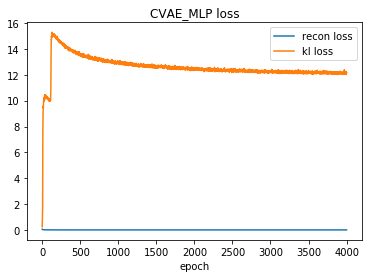

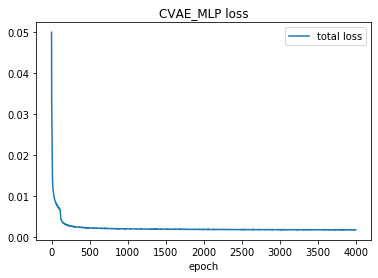

In [63]:
x = np.arange(0,max_epoch)

plt.figure()
l2 = plt.plot(x, epoch_recon_loss, label='recon loss')
l3 = plt.plot(x, epoch_kl_loss, label='kl loss')
plt.title('CVAE_MLP loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.figure()
l1 = plt.plot(x, epoch_loss, label='total loss')
plt.title('CVAE_MLP loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Visualization

88
(100, 104)
0.38469786876863377 0.8633639878377255
0.23772521251863377 0.2881467953365824


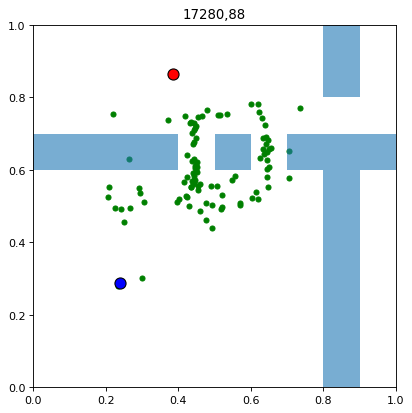

In [24]:
net = CVAE()
net.load_state_dict(torch.load(
    "/home/zhizuo/lego/models/CVAE_MLP_version1.pkl"))
num_viz = 100# sample points of landmark
#vizIdx = randint(0, numTest - 1)
vizIdx = np.random.choice(range(4297))
vizIdx = 88
print(vizIdx)
c_sample_seed = data[numTrain + vizIdx, 2:]
c_sample_seed = data[vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
path = data[numTrain + vizIdx, 0:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))
c_sample_seed = torch.FloatTensor(c_sample_seed)
#print(y_viz)
for i in range(num_viz):
    #print(i)
    z = torch.FloatTensor(np.random.randn(2))
    #print("fuck")
    #print(z)
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))

y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(path[0], path[1], color = 'green', s = 20)
plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

print(init[0], init[1])
print(goal[0], goal[1])
plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

                
plt.show()


# Visualization of more complex environment

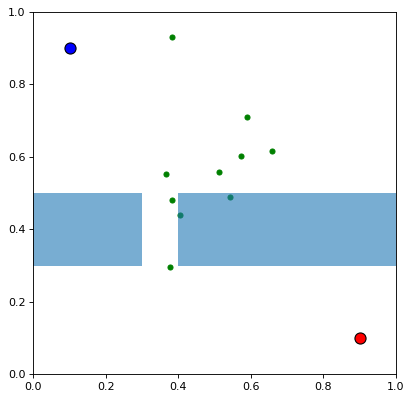

In [20]:
num_viz = 10 # sample points of landmark
c_sample_seed = np.array([0.9,0.1,0.1,0.9,1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1,\
                                          1,1,1,0,0,1,1,1,1,1])
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]
# Output each landmark points
net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))


c_sample_seed = torch.FloatTensor(c_sample_seed)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))


y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
#plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()

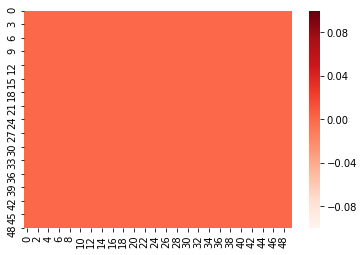

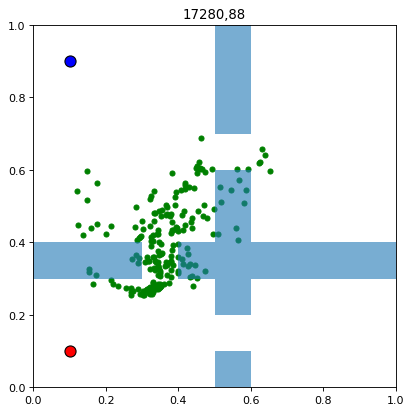

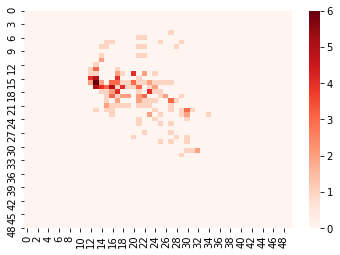

In [66]:
num_viz = 200 # sample points of landmark
import seaborn as sns
c_sample_seed = np.array([0.1,0.1,0.1,0.9,1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          0,1,0,0,0,0,1,0,0,0,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1])

occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]

# Output each landmark points
net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))


c_sample_seed = torch.FloatTensor(c_sample_seed)

grid = 50
heat_map = np.zeros((grid, grid));
    
        
sns.heatmap(heat_map, cmap = 'Reds')
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))
    

y_viz = y_viz.detach().numpy()
for i in range(num_viz):
    heat_map[int(y_viz[i][0]*grid)][int(y_viz[i][1]*grid)] += 1

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))
plt.show()
sns.heatmap(heat_map, cmap = 'Reds')
plt.show()

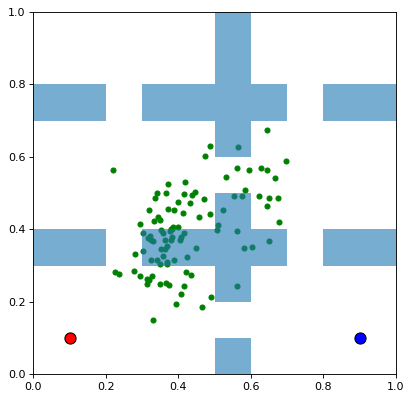

In [22]:
num_viz = 100 # sample points of landmark
c_sample_seed = np.array([0.1,0.1,0.9,0.1,1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          0,1,0,0,0,1,0,0,0,0,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1])

occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]

# Output each landmark points
net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))


c_sample_seed = torch.FloatTensor(c_sample_seed)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))


y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
#plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()

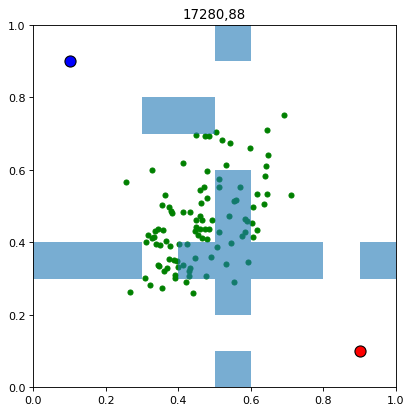

In [71]:
num_viz = 100 # sample points of landmark
c_sample_seed = np.array([0.9,0.1,0.1,0.9,1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,1,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          0,1,0,0,0,0,1,1,1,0,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1,\
                                          1,1,1,1,1,1,1,1,1,1,\
                                          1,1,1,0,1,1,1,1,1,1])

occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]

# Output each landmark points
net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))


c_sample_seed = torch.FloatTensor(c_sample_seed)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    y_viz[i,:] = net.decoder(torch.cat((z, c_sample_seed),0))


y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()

# Definition by using variance of Degree of freedom


In [18]:
graph = nx.Graph()
graph.add_node(1, coordinate = [1, 2])

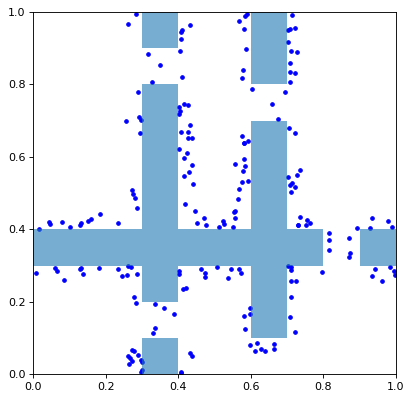

(488,)


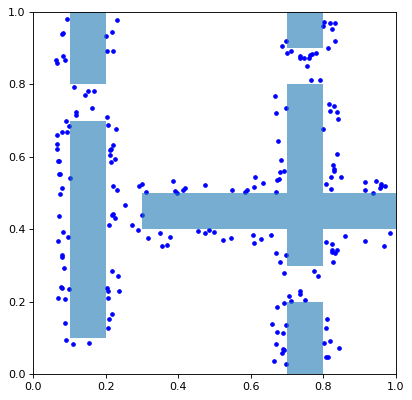

(502,)


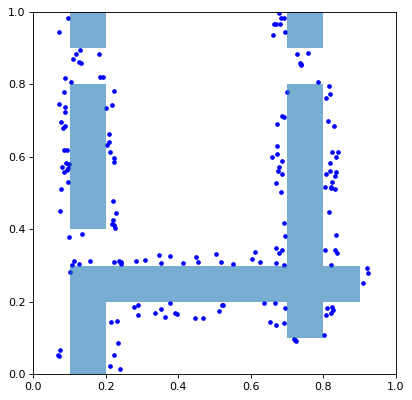

(438,)


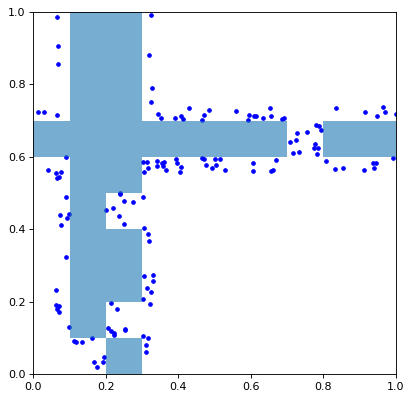

(380,)


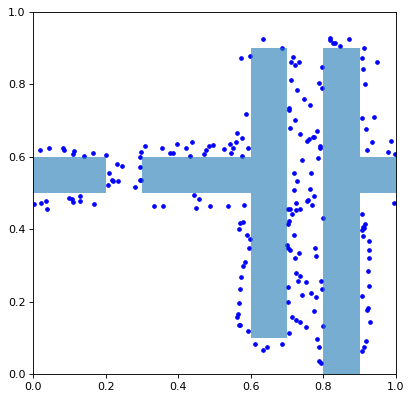

(494,)


In [109]:
import random

def get_rval(x):
    tmp = random.randint(0,99)
    if tmp%2:
        return random.randint(0,x-1)
    else:
        return random.randint(x+1,9)

def get_rval2(x):
    x1 = get_rval(x)
    x2 = get_rval(x)
    while abs(x1-x2)==1:
        x1 = get_rval(x)
        x2 = get_rval(x)
    return x1, x2

def get_random_occ_grid():
    row1 = random.randint(1,8)
    row2 = random.randint(1,8)
    while(row2 == row1 and row2 == row1 - 1 and row2 == row1 + 1):
        row2 = random.randint(1,8)
    col = random.randint(2,7)

    rc1, rc2 = get_rval2(col)
    cr1_1, cr1_2 = get_rval2(row1)
    cr2_1, cr2_2 = get_rval2(row2)

    occ_grid = np.ones((10,10))
    
    for i in range(10):
        if not (i==cr1_1 or i==cr1_2):
            occ_grid[row1,i] = 0

        if not (i==rc1 or i==rc2):
            occ_grid[i,col] = 0
            
        if not (i==cr2_1 or i==cr2_2):
            occ_grid[row2,i] = 0
            
            
    return occ_grid, row1, col
save_data = []
for num_data in range(5):
    data = occ_g.reshape(100)
    occ_g, row1, col = get_random_occ_grid()
    fig1 = plt.figure(figsize=(10,6), dpi=80)
    ax1 = fig1.add_subplot(111, aspect = 'equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    num_landmark = 1000
    num_neighbor = 200
    radius_landmark = 0.7
    #landmark = np.zeros((num_landmark, 2))
    graph = nx.Graph()
    cnt = 0
    for i in range(num_landmark):
        x = np.random.uniform(0, 10)
        y = np.random.uniform(0, 10)
        if occ_g[int(x)][int(y)] == 0:
            continue

        ratio = 0.0
        minus = 0.0
        for j in range(num_neighbor):
            r = np.random.uniform(0, radius_landmark)
            theta = np.random.uniform(0, 2*np.pi)
            x_ = x + r * np.cos(theta)
            y_ = y + r * np.sin(theta)
            #print(int(x_), int(y_))
            if x_ >= 10 or x_ <= 0 or y_ >= 10 or y_ <= 0:
                minus += 1
                continue
            if occ_g[int(x_)][int(y_)] == 1:
                ratio += 1
        ratio = ratio / (num_neighbor - minus)
        graph.add_node(i, coordinate = np.array([x, y]), rate = ratio, mean = 0, var = 0)
        if ratio <= 0.9:
            #print(ratio)
            data = np.append(data,x)
            data = np.append(data,y)
            plt.scatter(x/10, y/10, color = 'blue', s = 10)
    for i in range(10):
            for j in range(10):
                if(occ_g[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))

    plt.show()
    print(data.shape)
    np.save('/home/zhizuo/lego/dataset/landmark_{}.npz'.format(str(num_data)),data)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class LandmarkSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)

15992
(300, 104)


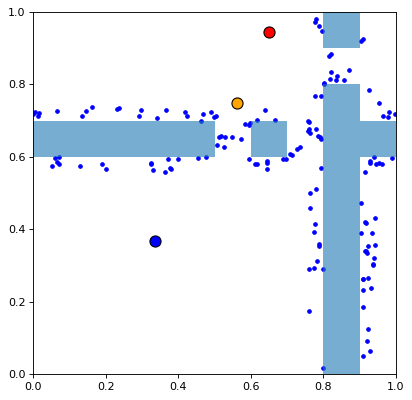

In [53]:
import networkx as nx
import operator

num_viz = 300
vizIdx = np.random.choice(range(4298+17192))
print(vizIdx)
c_sample_seed = data[vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]
path = data[vizIdx,0:2]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')


# ================
# variance of degree of freedom
# ================

num_landmark = 1000
num_neighbor = 200
radius_landmark = 0.7
#landmark = np.zeros((num_landmark, 2))
graph = nx.Graph()
cnt = 0
for i in range(num_landmark):
    x = np.random.uniform(0, 10)
    y = np.random.uniform(0, 10)
    if occ_g[int(x)][int(y)] == 0:
        continue
        
    ratio = 0.0
    minus = 0.0
    for j in range(num_neighbor):
        r = np.random.uniform(0, radius_landmark)
        theta = np.random.uniform(0, 2*np.pi)
        x_ = x + r * np.cos(theta)
        y_ = y + r * np.sin(theta)
        #print(int(x_), int(y_))
        if x_ >= 10 or x_ <= 0 or y_ >= 10 or y_ <= 0:
            minus += 1
            continue
        if occ_g[int(x_)][int(y_)] == 1:
            ratio += 1
    ratio = ratio / (num_neighbor - minus)
    graph.add_node(i, coordinate = np.array([x, y]), rate = ratio, mean = 0, var = 0)
    if ratio <= 0.9:
        #print(ratio)
        plt.scatter(x/10, y/10, color = 'blue', s = 10)
    
plt.xlim(0,1)
plt.ylim(0,1)

plt.scatter(path[0], path[1], color="orange", s=100, edgecolors='black')
plt.scatter(init[0], init[1], color="red", s=100, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=100, edgecolors='black') # goal


for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()


In [83]:
radius_check = 0.5
for i in list(graph.nodes()): 
    if i % 1000 == 0:
        print(i)
    for j in list(graph.nodes()):
        if i == j: 
            continue
        if np.linalg.norm(np.array(graph.nodes[i]['coordinate']) - np.array(graph.nodes[j]['coordinate'])) <= radius_check:
            graph.add_edge(i, j)
    
    
for i in list(graph.nodes()):
    mean = 0.0
    num = 0
    for j in graph.neighbors(i):
        ratio = graph.nodes[j]['rate']
        mean = mean + ratio
        num += 1
    if num == 0:
        continue
    mean = mean / num
    graph.nodes[i]['mean'] = mean

for i in list(graph.nodes()):
    var = 0
    mean = graph.nodes[i]['mean']
    cnt = 0
    for j in graph.neighbors(i):
        cnt += 1
        ratio = graph.nodes[j]['rate']
        var += (ratio - mean) * (ratio - mean)
    if cnt == 0:
        continue
    var /= cnt
    graph.nodes[i]['var'] = var
    
    

0


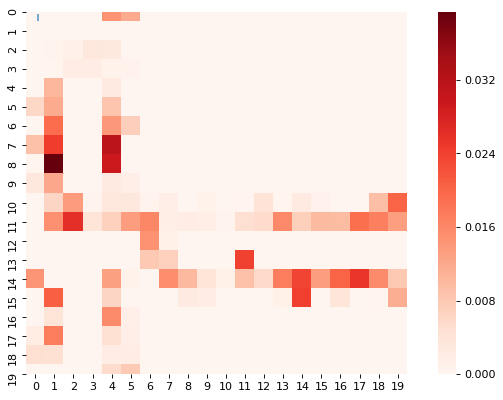

In [86]:
import seaborn as sns

'''
c_sample_seed = data[numTrain + vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
'''
#print(c_sample.shape)

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')
plt.xlim(0,1)
plt.ylim(0,1)

grid = 20
heat_map = np.zeros((grid, grid));
for i in list(graph.nodes()):
    var = graph.nodes[i]['var']
    if var >= 0.0:
        x = graph.nodes[i]['coordinate'][0]
        x /= 10
        y = graph.nodes[i]['coordinate'][1]
        y /= 10
        #plt.scatter(x, y, color = 'green', s = 10)
        heat_map[int(x*grid)][int(y*grid)] = var
        
sns.heatmap(heat_map, cmap = 'Reds')
for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))
plt.show()


In [136]:
layer = nn.ConvTranspose2d(2,1,10, stride=1,padding=0)
x = torch.randn(1,2,1,1)
print(x)
output = layer(x)
print(output.shape)

tensor([[[[0.7710]],

         [[1.2066]]]])
torch.Size([1, 1, 10, 10])


In [138]:
layer = nn.Conv2d(1,16,3,1,1)
x = torch.randn(1,1,10,10)
print(x.shape)
output = layer(x)
print(output.shape)

torch.Size([1, 1, 10, 10])
torch.Size([1, 16, 10, 10])
